# Class Description: Water Quality Data Analysis and Clustering with Python
### Overview:
In this class, students will learn how to perform data analysis and clustering on water quality data using Python. The class will focus on importing, cleaning, transforming, and visualizing data from various sources, and applying K-Means clustering to identify patterns. Students will also learn to evaluate the clustering performance using silhouette scores and visualize the clusters on a map. This hands-on class will provide practical experience in handling real-world environmental datasets.

### Objectives:
By the end of the class, students will be able to:

* Import and concatenate multiple CSV files into a single DataFrame.
* Clean and preprocess data, including handling outliers and converting timestamps.
* Perform data transformation and pivoting for analysis.
* Apply K-Means clustering to the dataset and interpret the results.
* Visualize data trends and clustering results using matplotlib and cartopy.
* Evaluate clustering performance using silhouette scores and inertia.
* Plot and interpret temporal curves for clustered data.

### Class Structure:

1. #### Data Import and Concatenation

* Reading multiple CSV files using glob and pandas.
* Concatenating DataFrames into a single DataFrame.
* Data Cleaning and Preprocessing (30 minutes)

2. #### Handling outliers with a custom function.
* Converting and formatting timestamps.
* Selecting and transforming relevant columns.

3. #### Data Transformation and Pivoting

* Pivoting the DataFrame for month-wise analysis.
* Extracting and integrating station coordinates from MATLAB files.

4. #### K-Means Clustering (30 minutes)

* Applying K-Means clustering to the data.
* Creating a DataFrame for cluster assignments.

5. #### Data Visualization

* Plotting monthly curves for each station.
* Visualizing clusters on a map using cartopy.
* Plotting temporal curves for each cluster.

6. #### Model Evaluation

* Calculating and interpreting silhouette scores.
* Using the elbow method to determine the optimal number of clusters.

In [1]:
import glob
import os
import json
import numpy as np
import pandas as pd
import scipy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
from matplotlib import dates
from matplotlib import cm
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# drop outlier function

def drop_outliers(df,varName,qmin,qmax):
    s_qmin_max = df[varName].quantile([qmin,qmax])
    newdf = df[(df[varName] > s_qmin_max[qmin]) & (df[varName] < s_qmin_max[qmax])]
    return newdf

In [3]:
outlierRange = (0,.96)
num_clusters = 3

In [4]:
import os 
os.chdir ("/Users/taky/Library/CloudStorage/GoogleDrive-tahmid@udel.edu/Other computers/My Laptop/UDel/Fall 2023/MAST 638_Machine Learning/MAST638_HWs")

In [5]:
dataFolder = './data/hw07_CEMA18'
station_file = './data/hw07_CEMA18/DE_stations.mat'

In [6]:
# load the test data

fileType = '*.csv'
fileList = glob.glob(os.path.join(dataFolder,fileType))

dfs = []
all_stations = None

for file in fileList:
    df = pd.read_csv(file)
    dfs.append(df)

all_stations = pd.concat(dfs)

In [7]:
# load the matlab file using scipy's io
station_coords = scipy.io.loadmat(station_file)

In [8]:
# clean up the data frame, drop outliers and transform

cols_to_keep = ['station_id','timestamp','chlora_value']

all_stations = all_stations[cols_to_keep]
all_stations['dateandtime'] = pd.to_datetime(all_stations['timestamp'])
all_stations['Month'] = all_stations['dateandtime'].dt.strftime('%m')
all_stations = all_stations.astype({'Month':'int'})
all_stations.set_index(['dateandtime'], inplace=True)
all_stations.drop(columns=['timestamp'],inplace=True)
all_stations.sort_index(inplace=True)

# reduce the station id to just the digits
all_stations['station_id'] = all_stations['station_id'].str[13:19]

#drop outliers based on the user provided range
for var_name in ['chlora_value']:
    all_stations = drop_outliers(all_stations,var_name,outlierRange[0],outlierRange[1])


In [9]:
# pivot the table to we have Months for columns and stations for the index
# the default aggregation function for Pandas pivot table is np.mean - resulting in the transform we're looking for

station_data = all_stations.pivot_table(index='station_id', columns='Month', values='chlora_value')

In [10]:
# doing some magic to get the station coordinates from the matlab file and getting them into a sorted
# dataframe that matches our data index so we can plot them later

coords_dict = {
    'stationID' : station_coords['stnIDs'],
    'lat'       : station_coords['stnlats'].flatten(),
    'lon'       : station_coords['stnlons'].flatten()
}

coords_df = pd.DataFrame.from_dict(coords_dict)
station_list = station_data.index.to_list()
coords_df = coords_df[coords_df['stationID'].isin(station_list)].sort_values('stationID')

In [11]:
# function to plot the monthly curves for each station

def plot_station_curves(df):
    
    fig_a, ax_a = plt.subplots(6,3, figsize=(12,8), sharex=True, sharey=True)
    axes = ax_a.ravel()
    
    i=0
    for station in df:
        axes[i].plot(df.index,df[station], '.-', alpha=0.75)
        axes[i].tick_params(top=False, bottom=False, right=False, left=False)
        axes[i].set_xlim(left=1, right=12)
        axes[i].set_ylim(top=30, bottom=0)
        axes[i].grid()
        axes[i].annotate(station,
                         xy=(0.75,0.75),
                         xycoords='axes fraction',
                         bbox=dict(boxstyle='round', fc=(1.0,1.0,1.0), ec='none')
                         )
        i = i + 1

    fig_a.supxlabel('Month')
    fig_a.supylabel('CHLA (mg/L)')
    fig_a.suptitle('Average Monthly CHLA per Station')
    
    fig_a.tight_layout()

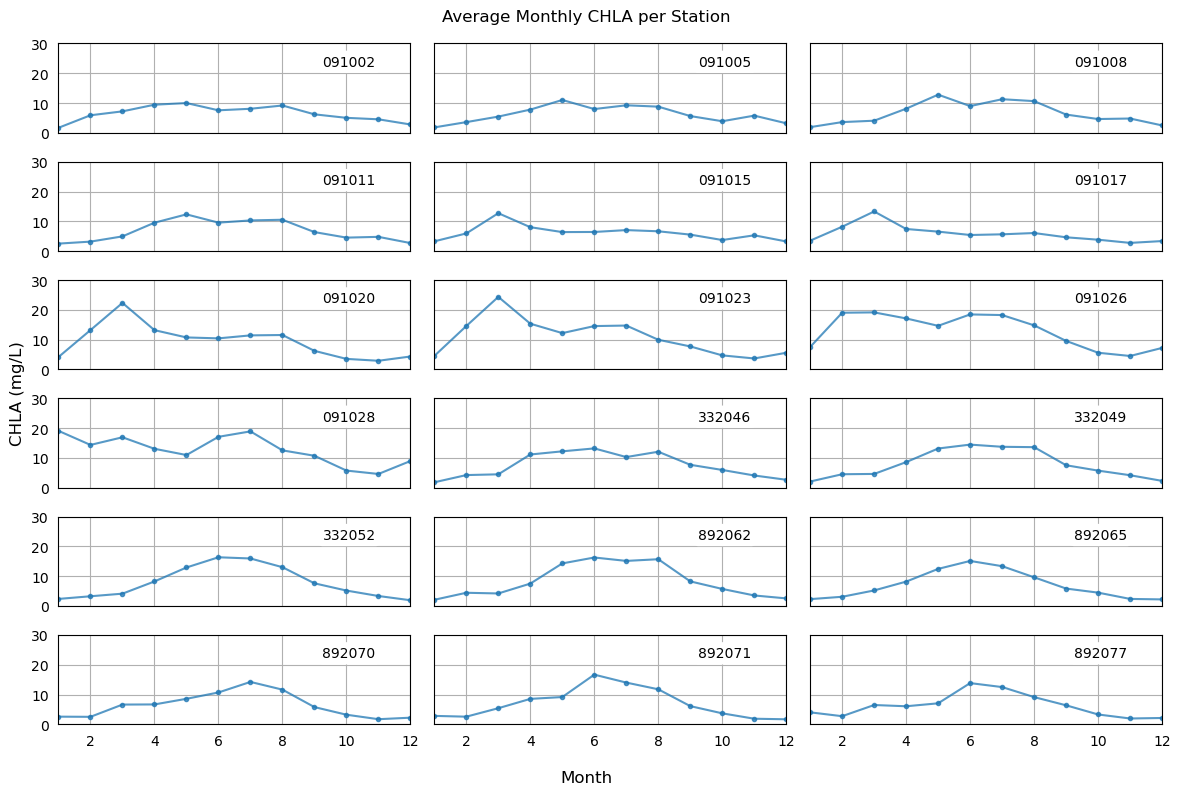

In [12]:
# transpose our dataframe for ease in plotting
st = station_data.T

#plot it
plot_station_curves(st)

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

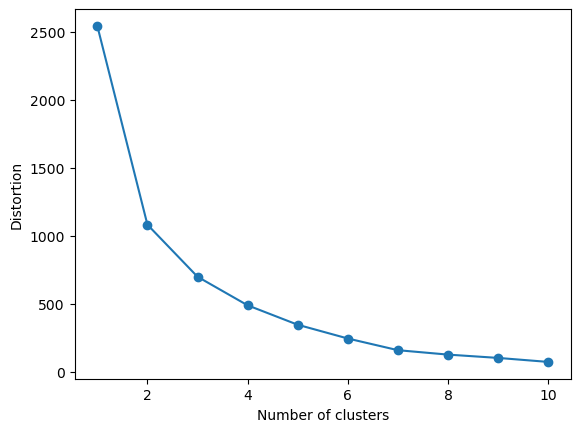

In [13]:
# elbow method from Raschka and Mirjalili, Ch. 11, pp 362

distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(station_data)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout

# save code here

In [14]:
# run the KMeans with our chosen number of clusters for the remaining analysis

km = KMeans(n_clusters=num_clusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
station_outputs = pd.DataFrame(index=station_data.index)
station_outputs['one'] = km.fit_predict(station_data)

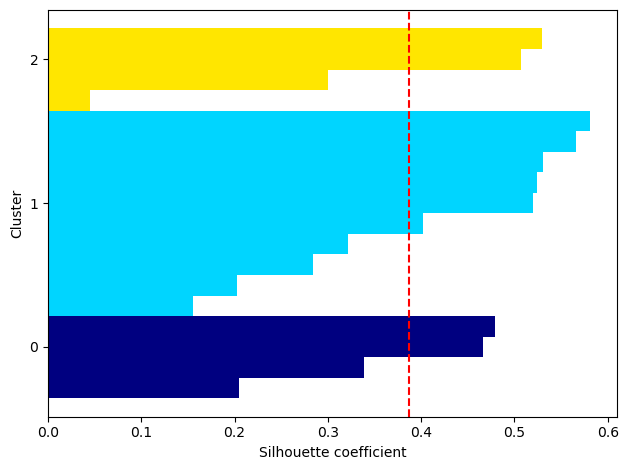

In [15]:
# plot the silhouette for this run

cluster_labels = np.unique(station_outputs['one'])
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(station_data, station_outputs['one'], metric='euclidean')

y_ax_lower, y_ax_upper = 0,0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[station_outputs['one'] == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

# save code here

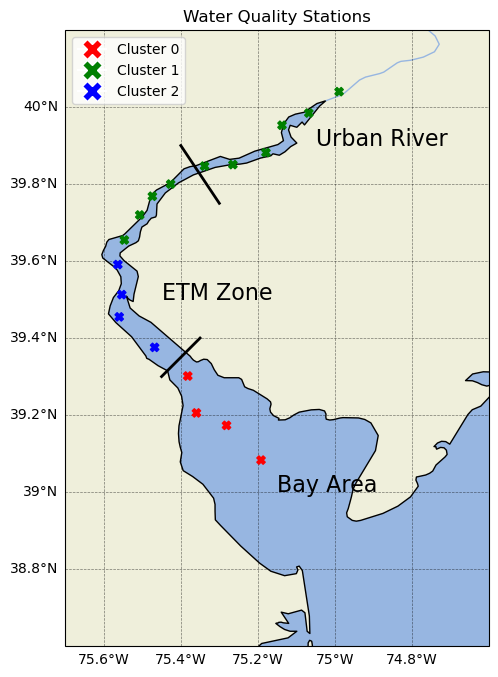

In [16]:
# Plot the stations on the map and color them according to their cluster

colors = {0:'red', 1:'green', 2:'blue'}

legend_elements = [Line2D([0], [0], marker='X', color='w', label='Cluster 0',
                          markerfacecolor=colors[0], markersize=15),
                   Line2D([0], [0], marker='X', color='w', label='Cluster 1',
                          markerfacecolor=colors[1], markersize=15),
                   Line2D([0], [0], marker='X', color='w', label='Cluster 2',
                          markerfacecolor=colors[2], markersize=15)
                   ]

months = [1,2,3,4,5,6,7,8,9,10,11,12]
line1 = [[-75.4,-75.3],[39.9,39.75]]
line2 = [[-75.45,-75.35],[39.3,39.4]]

proj=ccrs.PlateCarree()

fig, ax_map = plt.subplots(figsize=(11,8),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.set_xlim(left=-75.7,right=-74.6)
ax_map.set_ylim(bottom=38.6,top=40.2)

ax_map.set_xlabel('longitude (deg W)')
ax_map.set_ylabel('latitude (deg N)')

ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.OCEAN)
ax_map.add_feature(cfeature.LAND)
ax_map.add_feature(cfeature.RIVERS)

ax_map.text(-75.05, 39.9, 'Urban River', fontsize = 16)
ax_map.text(-75.45, 39.5, 'ETM Zone', fontsize = 16)
ax_map.text(-75.15, 39, 'Bay Area', fontsize = 16)

ax_map.plot(line1[0], line1[1], color="black", linewidth=2)
ax_map.plot(line2[0], line2[1], color="black", linewidth=2)

ax_map.set_title('Water Quality Stations')

ax_map.legend(handles=legend_elements, loc='upper left')

ax_map.scatter(coords_df['lon'], coords_df['lat'], marker='X', c=station_outputs['one'].map(colors), zorder=5)
gls = ax_map.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', 
          draw_labels=True, alpha=0.5, linestyle='--')
gls.top_labels=False
gls.right_labels=False
gls.xlocator = ticker.FixedLocator([-75.6, -75.4, -75.2, -75.0, -74.8, -74.6])

# save code here


Text(0.5, 0, 'month of year')

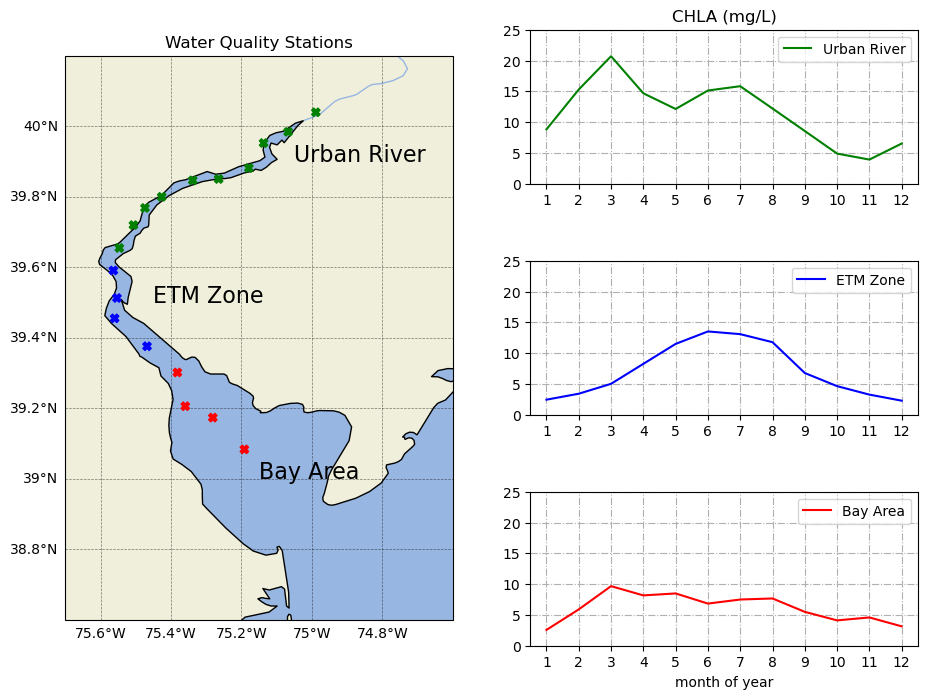

In [17]:
# Plot the temporal curves to accompany the station clusters

chlafig = plt.figure(figsize=(11,8))
gs = GridSpec(3,4, figure=chlafig, hspace=0.5, wspace=0.5)

ax_map = chlafig.add_subplot(gs[0:,0:2],projection=proj)
ax_urb = chlafig.add_subplot(gs[0,2:])
ax_etm = chlafig.add_subplot(gs[1,2:])
ax_bay = chlafig.add_subplot(gs[2,2:])

ax_map.set_xlim(left=-75.7,right=-74.6)
ax_map.set_ylim(bottom=38.6,top=40.2)

ax_map.set_xlabel('longitude (deg W)')
ax_map.set_ylabel('latitude (deg N)')

ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.OCEAN)
ax_map.add_feature(cfeature.LAND)
ax_map.add_feature(cfeature.RIVERS)

ax_map.text(-75.05, 39.9, 'Urban River', fontsize = 16)
ax_map.text(-75.45, 39.5, 'ETM Zone', fontsize = 16)
ax_map.text(-75.15, 39, 'Bay Area', fontsize = 16)

ax_map.set_title('Water Quality Stations')

ax_map.scatter(coords_df['lon'], coords_df['lat'], marker='X', c=station_outputs['one'].map(colors), zorder=5)
gls = ax_map.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', 
          draw_labels=True, alpha=0.5, linestyle='--')
gls.top_labels=False
gls.right_labels=False
gls.xlocator = ticker.FixedLocator([-75.6, -75.4, -75.2, -75.0, -74.8, -74.6])

ax_urb.grid(visible=True,which='both',linestyle='-.')
ax_urb.plot(months,km.cluster_centers_[0], label='Urban River', color=colors[1])
ax_urb.set_xlim(left=0.5, right=12.5)
ax_urb.set_ylim(bottom=0, top=25)
ax_urb.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax_urb.legend(loc='best')
ax_urb.set_title('CHLA (mg/L)')

ax_etm.grid(visible=True,which='both',linestyle='-.')
ax_etm.plot(months,km.cluster_centers_[1], label='ETM Zone', color=colors[2])
ax_etm.set_xlim(left=0.5, right=12.5)
ax_etm.set_ylim(bottom=0, top=25)
ax_etm.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax_etm.legend(loc='best')

ax_bay.grid(visible=True,which='both',linestyle='-.')
ax_bay.plot(months,km.cluster_centers_[2], label='Bay Area', color=colors[0])
ax_bay.set_xlim(left=0.5, right=12.5)
ax_bay.set_ylim(bottom=0, top=25)
ax_bay.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax_bay.legend(loc='best')
ax_bay.set_xlabel('month of year')

#chlafig.savefig('/Users/ryaneagan/Desktop/hw1_chla.png')